# **Malaria Cell Classification with VGG16**

In this project, I have used Convolutional Neural Network (CNN) using VGG16 Pre-Trained Model to classify Malaria cell images as Parasitized or Uninfected. The dataset is available at https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria. I have split the dataset into 80% training and 20% validation sets. The total number of training and testing images are 22046 and 5512 respectively. The dataset contains equal number of images in both the classes. I have implemented the code using tensorflow and keras. I have obtained a validation accuracy of over 91%, training for 10 epochs only.

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import fnmatch
import tensorflow as tf
from time import sleep
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Dropout,Flatten,BatchNormalization,MaxPooling2D,Activation
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as k
import matplotlib.image as mpimg

from tensorflow.keras import layers
from tensorflow.keras import Model

from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
plt.rcParams['figure.figsize'] = (12,7)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Define dataset path
data_dir = "/content/drive/MyDrive/Colab Notebooks/cell_images"

Mounted at /content/drive


In [ ]:
infected_path = "/content/drive/MyDrive/Colab Notebooks/cell_images/Parasitized"
uninfected_path = "/content/drive/MyDrive/Colab Notebooks/cell_images/Uninfected"

# List images
infected = os.listdir(infected_path)
uninfected = os.listdir(uninfected_path)

print("Length of infected data =", len(infected), "images")
print("Length of uninfected data =", len(uninfected), "images")

Length of infected data = 13790 images
Length of uninfected data = 13780 images


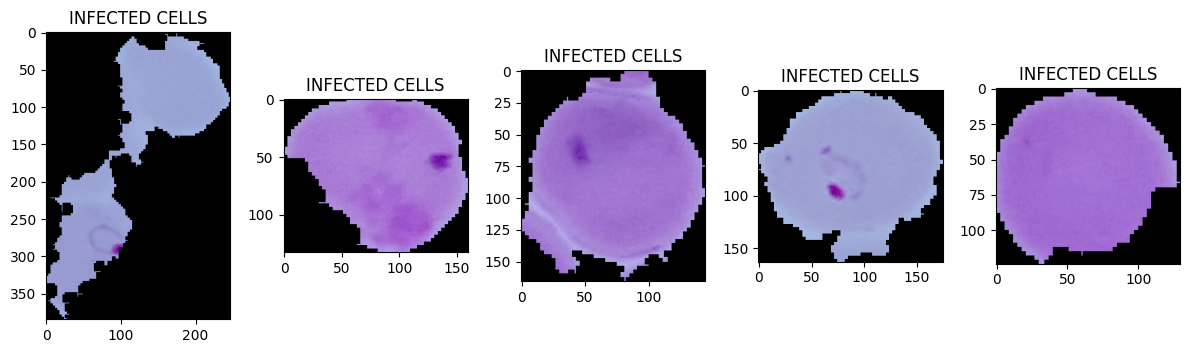

In [ ]:
# Infected cells

for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(cv2.imread(infected_path + '/' + infected[i]))
    plt.title('INFECTED CELLS')
    plt.tight_layout()
plt.show()

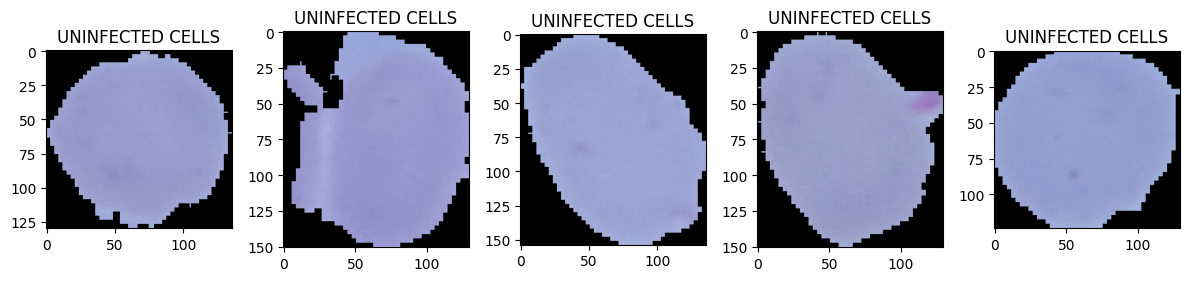

In [ ]:
# Uninfected cells

for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(cv2.imread(uninfected_path + '/' + uninfected[i]))
    plt.title('UNINFECTED CELLS')
    plt.tight_layout()
plt.show()

In [ ]:
# Defining Image Data Gen

img_shape = (130, 130, 3)
image_gen = ImageDataGenerator(rotation_range=20,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              rescale=1/225,
                              shear_range=0.1,
                              zoom_range=0.1,
                              horizontal_flip=True,
                              fill_mode='nearest',
                              validation_split=0.2)

In [ ]:
train = image_gen.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/cell_images',
                                     target_size = img_shape[:2],
                                     color_mode = 'rgb',
                                     batch_size = 32,
                                     class_mode = 'binary',
                                     subset = 'training',
                                     shuffle = True)

validation = image_gen.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/cell_images',
                                     target_size = img_shape[:2],
                                     color_mode ='rgb',
                                     batch_size = 32,
                                     class_mode = 'binary',
                                     subset = 'validation',
                                     shuffle = False)


Found 22056 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.


In [ ]:
train.class_indices

{'Parasitized': 0, 'Uninfected': 1}

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
base_model = VGG16(input_shape = (130, 130, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
#Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = 'adam' , loss = 'binary_crossentropy',metrics = ['acc'])

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 130, 130, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 130, 130, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 130, 130, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 65, 65, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 65, 65, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 65, 65, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       4,194,816 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 18,910,017 (72.14 MB)

 Trainable params: 4,195,329 (16.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [13]:
vgghist = model.fit(train, validation_data = validation, steps_per_epoch = 100, epochs = 10)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 4817s 48s/step - acc: 0.7359 - loss: 0.6546 - val_acc: 0.8910 - val_loss: 0.2742
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2704s 27s/step - acc: 0.8742 - loss: 0.3025 - val_acc: 0.9037 - val_loss: 0.2529
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2466s 25s/step - acc: 0.9017 - loss: 0.2499 - val_acc: 0.9089 - val_loss: 0.2272
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2258s 23s/step - acc: 0.9086 - loss: 0.2454 - val_acc: 0.9106 - val_loss: 0.2318
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2059s 21s/step - acc: 0.8952 - loss: 0.2630 - val_acc: 0.9095 - val_loss: 0.2334
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1896s 19s/step - acc: 0.9121 - loss: 0.2344 - val_acc: 0.9048 - val_loss: 0.2346
Epoch 7/10
 90/100 ━━━━━━━━━━━━━━━━━━━━ 1:08 7s/step - acc: 0.9149 - loss: 0.2183

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


100/100 ━━━━━━━━━━━━━━━━━━━━ 1808s 18s/step - acc: 0.9143 - loss: 0.2191 - val_acc: 0.9120 - val_loss: 0.2244
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1930s 19s/step - acc: 0.9043 - loss: 0.2415 - val_acc: 0.9087 - val_loss: 0.2237
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1924s 19s/step - acc: 0.9030 - loss: 0.2318 - val_acc: 0.9089 - val_loss: 0.2202
Epoch 10/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1899s 19s/step - acc: 0.8950 - loss: 0.2581 - val_acc: 0.9173 - val_loss: 0.2090


In [14]:
model.save("/content/drive/MyDrive/malaria_detection_modelvgg16.h5")

Available keys: dict_keys(['acc', 'loss', 'val_acc', 'val_loss'])


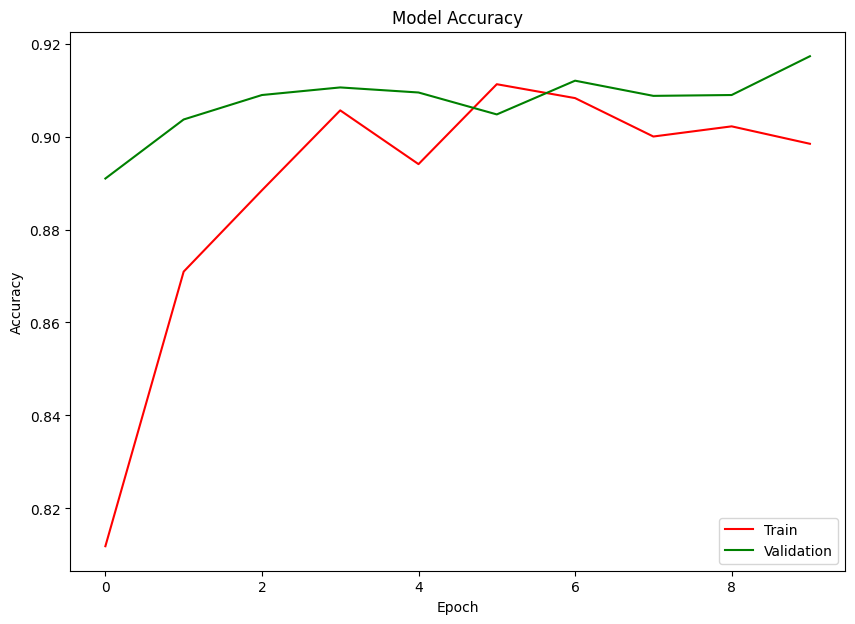

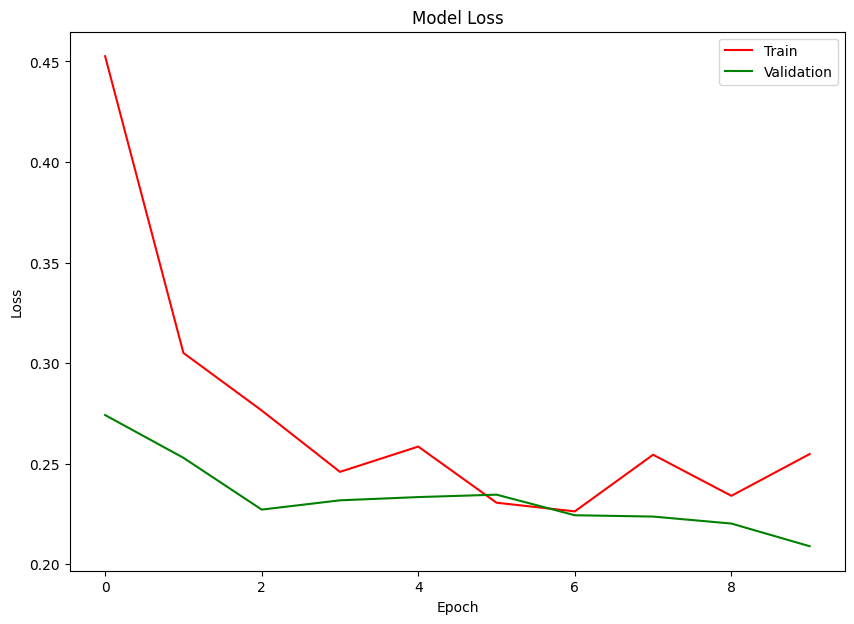

In [17]:
import matplotlib.pyplot as plt

# ✅ Check available history keys
history_keys = vgghist.history.keys()
print("Available keys:", history_keys)

# ✅ Use correct key names based on available history
train_acc_key = 'accuracy' if 'accuracy' in history_keys else 'acc'
val_acc_key = 'val_accuracy' if 'val_accuracy' in history_keys else 'val_acc'

# ✅ Plot Model Accuracy
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)
ax.set_facecolor('w')
ax.grid(False)
ax.plot(vgghist.history[train_acc_key], color='red')
ax.plot(vgghist.history[val_acc_key], color='green')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# ✅ Plot Model Loss
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)
ax.set_facecolor('w')
ax.grid(False)
ax.plot(vgghist.history['loss'], color='red')
ax.plot(vgghist.history['val_loss'], color='green')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
                                          Image_Path Actual_Label  \
0  /content/drive/MyDrive/Colab Notebooks/cell_im...  Parasitized   
1  /content/drive/MyDrive/Colab Notebooks/cell_im...  Parasitized   
2  /content/drive/MyDrive/Colab Notebooks/cell_im...   Uninfected   
3  /content/drive/MyDrive/Colab Notebooks/cell_im...   Uninfected   
4  /content/drive/MyDrive/Colab Notebooks/cell_im...  Parasitized   

  Predicted_Label  Confidence  
0     Parasitized    0.020670  
1     Parasitized    0.000001  
2      Uninfected    0.967856  
3      Uninfected    0.954753  
4     Parasitized    0.021642  
Pre

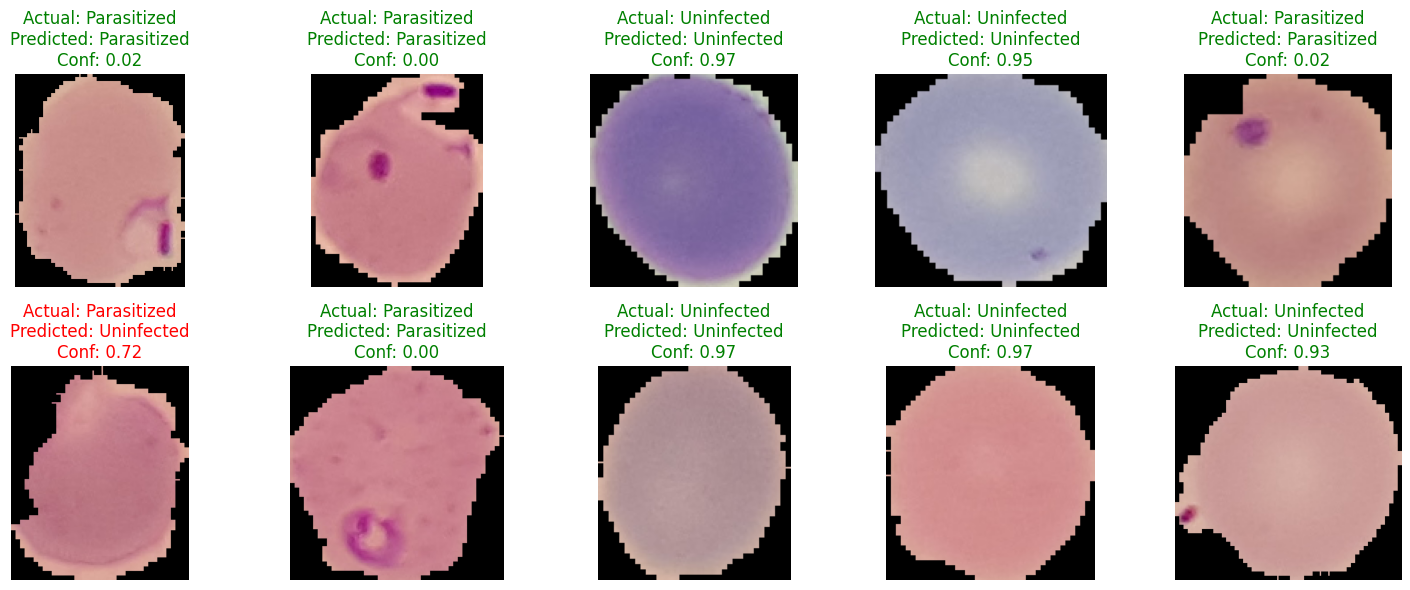

In [19]:
import tensorflow as tf
import numpy as np
import cv2
import os
import pandas as pd
import random
import matplotlib.pyplot as plt
from google.colab import drive

# ✅ Step 1: Mount Google Drive & Load Model
drive.mount('/content/drive')
model_path = "/content/drive/MyDrive/malaria_detection_modelvgg16.h5"
model = tf.keras.models.load_model(model_path)

# ✅ Step 2: Set Dataset Paths (Parasitized & Uninfected)
data_dir = "/content/drive/MyDrive/Colab Notebooks/cell_images"
parasitized_dir = os.path.join(data_dir, "Parasitized")
uninfected_dir = os.path.join(data_dir, "Uninfected")

# ✅ Get random images from both classes
num_samples = 10  # Adjust the number of images to test
parasitized_images = random.sample(os.listdir(parasitized_dir), num_samples // 2)
uninfected_images = random.sample(os.listdir(uninfected_dir), num_samples // 2)

# ✅ Combine file paths and actual labels
test_images = [(os.path.join(parasitized_dir, img), "Parasitized") for img in parasitized_images] + \
              [(os.path.join(uninfected_dir, img), "Uninfected") for img in uninfected_images]

random.shuffle(test_images)  # Shuffle images for fairness

# ✅ Step 3: Preprocess Function
def preprocess_image(img_path):
    """Load, preprocess, and normalize an image."""
    IMG_SIZE = (130, 130)  # Match training size
    img = cv2.imread(img_path)  # Read image
    img = cv2.resize(img, IMG_SIZE)  # Resize
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = img / 255.0  # ✅ Fix normalization
    return np.expand_dims(img, axis=0)  # Add batch dimension

# ✅ Step 4: Predict & Store Actual vs Predicted Labels
results = []
for img_path, actual_label in test_images:
    img_array = preprocess_image(img_path)
    pred_prob = model.predict(img_array)[0][0]  # Get probability
    predicted_label = "Uninfected" if pred_prob > 0.5 else "Parasitized"
    results.append((img_path, actual_label, predicted_label, pred_prob))

# ✅ Step 5: Convert to DataFrame
df_results = pd.DataFrame(results, columns=["Image_Path", "Actual_Label", "Predicted_Label", "Confidence"])

# ✅ Step 6: Display Actual vs Predicted Labels
print(df_results.head())  # Show first few rows of results

# ✅ Step 7: Save results as a CSV file in Google Drive
csv_path = "/content/drive/MyDrive/malaria_predictions1.csv"
df_results.to_csv(csv_path, index=False)
print(f"Predictions saved to Google Drive: {csv_path}")

# ✅ Step 8: Show Sample Predictions with Images
def visualize_predictions(results, num_samples=10):
    """Display test images with actual vs predicted labels."""
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # Show 10 images

    for i, ax in enumerate(axes.flat[:num_samples]):
        img_path, actual, predicted, confidence = results[i]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        ax.imshow(img)
        ax.axis("off")
        ax.set_title(f"Actual: {actual}\nPredicted: {predicted}\nConf: {confidence:.2f}",
                     color="green" if actual == predicted else "red")

    plt.tight_layout()
    plt.show()

# ✅ Step 9: Call Function to Display Predictions
visualize_predictions(results, num_samples=10)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s

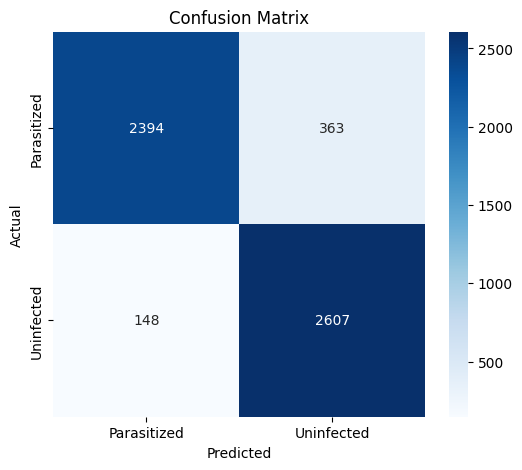

Classification Report:
               precision    recall  f1-score   support

 Parasitized       0.94      0.87      0.90      2757
  Uninfected       0.88      0.95      0.91      2755

    accuracy                           0.91      5512
   macro avg       0.91      0.91      0.91      5512
weighted avg       0.91      0.91      0.91      5512



In [20]:
# ✅ Step 8: Generate Predictions for Confusion Matrix
y_true = []
y_pred = []

for i in range(len(validation)):
    images, labels = validation[i]  # Get batch
    preds = model.predict(images)  # Predict
    preds = (preds > 0.5).astype(int).flatten()  # Convert probabilities to binary labels

    y_true.extend(labels)
    y_pred.extend(preds)

# ✅ Step 9: Compute Confusion Matrix & Classification Report
cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=["Parasitized", "Uninfected"])

# ✅ Step 10: Display Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Parasitized", "Uninfected"], yticklabels=["Parasitized", "Uninfected"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ✅ Step 11: Print Classification Report
print("Classification Report:\n", report)